######Name: Chandni Patel
######ID: A20455322
######CS 512 - Fall 2020

In [1]:
import numpy as np
import tensorflow as tf
import keras
from keras import models
from keras import layers
from keras.layers import BatchNormalization
from keras.layers import LayerNormalization
from keras.datasets import mnist
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from matplotlib.pylab import imshow
import matplotlib.cm as cm
import cv2
from google.colab import files
from google.colab.patches import cv2_imshow


#Data

In [2]:
#load data
(images, labels), (val_images, val_labels) = mnist.load_data()

#split into train, validation & test
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.08333)
train_images = train_images.reshape((55000,28,28,1))
train_images = train_images.astype('float32') / 255
val_images = val_images.reshape((10000,28,28,1))
val_images = val_images.astype('float32') / 255
test_images = test_images.reshape((5000,28,28,1))
test_images = test_images.astype('float32') / 255
print("Train: ", train_images.shape[0], "\nValidation: ", val_images.shape[0], "\nTest: ", test_images.shape[0])


Train:  55000 
Validation:  10000 
Test:  5000


In [3]:
#function to convert labels to odd/even
def GetOddEvenLabels(digitlabels):
  oddeven = []
  for l in digitlabels:
    if l%2 == 0:
      oddeven.append(0)
    else:
      oddeven.append(1)
  return oddeven
  

In [4]:
#convert labels to odd/even
train_labels_oddeven = to_categorical(GetOddEvenLabels(train_labels))
val_labels_oddeven = to_categorical(GetOddEvenLabels(val_labels))
test_labels_oddeven = to_categorical(GetOddEvenLabels(test_labels))


In [5]:
#print samples to check labels
sample = 7
data = train_images[sample]
print("Original Label",train_labels[sample])
print("Odd/Even Label",train_labels_oddeven[sample])
sample = 70
data = train_images[sample]
print("Original Label",train_labels[sample])
print("Odd/Even Label",train_labels_oddeven[sample])


Original Label 2
Odd/Even Label [1. 0.]
Original Label 7
Odd/Even Label [0. 1.]


#Construct and train CNN

In [6]:
#model
cnn = models.Sequential()

#two convolution layers with pooling
cnn.add(layers.Conv2D(32,(3,3), activation = 'relu', input_shape = (28,28,1)))
cnn.add(layers.MaxPooling2D((2,2)))
cnn.add(layers.Conv2D(64,(3,3), activation = 'relu'))
cnn.add(layers.MaxPooling2D((2,2)))
cnn.add(layers.Conv2D(64,(3,3), activation = 'relu'))

#dropout layer
cnn.add(layers.Dropout(0.3))

#flatten
cnn.add(layers.Flatten())

#two fully connected layers
cnn.add(layers.Dense(64,activation='relu'))
cnn.add(layers.Dense(2,activation='sigmoid'))

#summary
cnn.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 576)               0

In [7]:
#select Loss function, Optimization algorithm & Evalution metrix
cnn.compile(optimizer='sgd', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
train_results = cnn.fit(train_images, train_labels_oddeven, epochs=5
                  , batch_size=64, validation_data=(val_images,val_labels_oddeven))


Epoch 1/5
860/860 [==============================] - 48s 55ms/step - loss: 0.5138 - accuracy: 0.7741 - val_loss: 0.3059 - val_accuracy: 0.8723
Epoch 2/5
860/860 [==============================] - 48s 55ms/step - loss: 0.2616 - accuracy: 0.8944 - val_loss: 0.1713 - val_accuracy: 0.9367
Epoch 3/5
860/860 [==============================] - 48s 55ms/step - loss: 0.1683 - accuracy: 0.9377 - val_loss: 0.1235 - val_accuracy: 0.9553
Epoch 4/5
860/860 [==============================] - 48s 56ms/step - loss: 0.1211 - accuracy: 0.9566 - val_loss: 0.0796 - val_accuracy: 0.9721
Epoch 5/5
860/860 [==============================] - 48s 56ms/step - loss: 0.0971 - accuracy: 0.9658 - val_loss: 0.0635 - val_accuracy: 0.9784


In [8]:
#train the network and record loss and accuracy
test_loss, test_accuracy = cnn.evaluate(test_images, test_labels_oddeven)


157/157 [==============================] - 2s 10ms/step - loss: 0.0765 - accuracy: 0.9720


In [9]:
#function to plot training and validation loss and accuracy
def GetLossAccuracyPlot():
  #plot loss
  plt.subplot(1, 2, 1)
  plt.plot(train_results.history['loss'])
  plt.plot(train_results.history['val_loss'])
  plt.title('Training & Validation loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Training', 'Validation'])

  #plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(train_results.history['accuracy'])
  plt.plot(train_results.history['val_accuracy'])
  plt.title('Training & Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Training', 'Validation'])


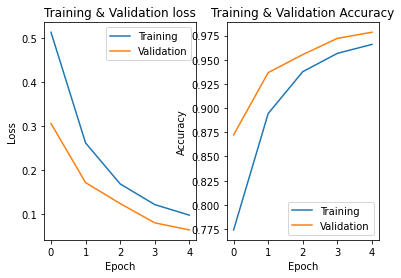

In [10]:
#plot training and validation results
GetLossAccuracyPlot()


#Hyper-parameter Tuning

####Changing the network architecture

In [11]:
def CNN(dilation_value = 1, stride_value = 1
        , optimizer_value = keras.optimizers.SGD()
        , loss_function = 'binary_crossentropy', dropout_value = 0.3
        , epoch_value = 5, weight_initializer = 'glorot_uniform'):
  cnn = models.Sequential()
  cnn.add(layers.Conv2D(64,(3,3), strides=stride_value, dilation_rate=dilation_value, activation = 'relu', input_shape = (28,28,1)))
  cnn.add(layers.MaxPooling2D((2,2)))
  cnn.add(layers.Conv2D(64,(3,3), strides=stride_value, dilation_rate=dilation_value, activation = 'relu'))
  cnn.add(layers.Dropout(dropout_value))
  cnn.add(layers.Flatten())
  cnn.add(layers.Dense(64,activation='relu',kernel_initializer=weight_initializer))
  cnn.add(layers.Dense(32,activation='relu',kernel_initializer=weight_initializer))
  cnn.add(layers.Dense(16,activation='relu',kernel_initializer=weight_initializer))
  cnn.add(layers.Dense(2,activation='sigmoid'))
  cnn.summary()

  cnn.compile(optimizer=optimizer_value, loss=loss_function, metrics=['accuracy'])
  train_results = cnn.fit(train_images, train_labels_oddeven, epochs=epoch_value
                    , batch_size=64, validation_data=(val_images,val_labels_oddeven))
  print('\nTest:')
  test_loss, test_accuracy = cnn.evaluate(test_images, test_labels_oddeven)  

#new network architecture
CNN();

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 11, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7744)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                495680    
_________________________________________________________________
dense_3 (Dense)              (None, 32)               

####Changing the receptive field

In [12]:
# dilation_rate ==> 2,3
for i in range(2,4):
  print("\n\ndilation_rate = ", i)
  CNN(dilation_value = i)




dilation_rate =  2
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 24, 24, 64)        640       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                262208    
_________________________________________________________________
dense_7 (Dense)              (Non

####Changing the stride parameter

In [13]:
# strides ==> 2,3
for i in range(2,4):
  print("\n\nstrides = ", i)
  CNN(stride_value = i)




strides =  2
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 13, 13, 64)        640       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 2, 2, 64)          36928     
_________________________________________________________________
dropout_4 (Dropout)          (None, 2, 2, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_15 (Dense)             (None, 32)

####Changing the optimizer

In [17]:
# optimizer = adam, rmsprop
print("optimizer = adam")
CNN(optimizer_value = keras.optimizers.Adam())
print("optimizer = rmsprop")
CNN(optimizer_value = keras.optimizers.RMSprop())

best_opt = keras.optimizers.Adam()


optimizer = adam
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 11, 11, 64)        36928     
_________________________________________________________________
dropout_11 (Dropout)         (None, 11, 11, 64)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 7744)              0         
_________________________________________________________________
dense_42 (Dense)             (None, 64)                495680    
_________________________________________________________________
dense_43 (Dense)             (None, 

####Changing the loss function

In [18]:
# loss = poisson, categorical_crossentropy
print("loss = poisson")
CNN(optimizer_value = best_opt, loss_function = 'poisson')
print("loss = categorical_crossentropy")
CNN(optimizer_value = best_opt, loss_function = 'categorical_crossentropy')


loss = poisson
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 11, 11, 64)        36928     
_________________________________________________________________
dropout_13 (Dropout)         (None, 11, 11, 64)        0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 7744)              0         
_________________________________________________________________
dense_50 (Dense)             (None, 64)                495680    
_________________________________________________________________
dense_51 (Dense)             (None, 32

####Changing the dropout parameter

In [19]:
# dropout ==> 0.5,0.7
dropout = [0.5,0.7]
for i in range(0,len(dropout)):
  print("dropout = ", dropout[i])
  CNN(optimizer_value = best_opt, dropout_value = dropout[i])


dropout =  0.5
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 11, 11, 64)        36928     
_________________________________________________________________
dropout_15 (Dropout)         (None, 11, 11, 64)        0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 7744)              0         
_________________________________________________________________
dense_58 (Dense)             (None, 64)                495680    
_________________________________________________________________
dense_59 (Dense)             (None, 32

####Changing the learning rate

In [20]:
# learning_rate ==> 0.1, 0.01
learning = [0.1, 0.01]
for i in range(0,len(learning)):
  print("learning_rate = ", learning[i])
  CNN(optimizer_value = keras.optimizers.Adam(learning[i]))


learning_rate =  0.1
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 11, 11, 64)        36928     
_________________________________________________________________
dropout_17 (Dropout)         (None, 11, 11, 64)        0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 7744)              0         
_________________________________________________________________
dense_66 (Dense)             (None, 64)                495680    
_________________________________________________________________
dense_67 (Dense)             (No

####Using weight initializer

In [21]:
# kernel_initializer = he_uniform, he_normal
print("kernel_initializer = he_uniform")
CNN(optimizer_value = best_opt, weight_initializer = 'he_uniform')
print("kernel_initializer = he_normal")
CNN(optimizer_value = best_opt, weight_initializer = 'he_normal')


kernel_initializer = he_uniform
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 11, 11, 64)        36928     
_________________________________________________________________
dropout_19 (Dropout)         (None, 11, 11, 64)        0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 7744)              0         
_________________________________________________________________
dense_74 (Dense)             (None, 64)                495680    
_________________________________________________________________
dense_75 (Dense)     

####Adding batch normalization

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 64)        256       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 13, 64)        256       
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 11, 11, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 11, 11, 64)        256       
_________________________________________________________________
dropout_21 (Dropout)         (None, 11, 11, 64)      

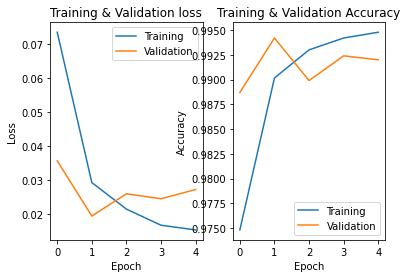

In [22]:
cnn = models.Sequential()
cnn.add(layers.Conv2D(64,(3,3), strides=1, dilation_rate=1, activation = 'relu', input_shape = (28,28,1)))
cnn.add(BatchNormalization())
cnn.add(layers.MaxPooling2D((2,2)))
cnn.add(BatchNormalization())
cnn.add(layers.Conv2D(64,(3,3), strides=1, dilation_rate=1, activation = 'relu'))
cnn.add(BatchNormalization())
cnn.add(layers.Dropout(0.5))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(64,activation='relu',kernel_initializer='he_normal'))
cnn.add(layers.Dense(32,activation='relu',kernel_initializer='he_normal'))
cnn.add(layers.Dense(16,activation='relu',kernel_initializer='he_normal'))
cnn.add(layers.Dense(2,activation='sigmoid'))
cnn.summary()

cnn.compile(optimizer=best_opt, loss='binary_crossentropy', metrics=['accuracy'])
train_results = cnn.fit(train_images, train_labels_oddeven, epochs=5
                  , batch_size=64, validation_data=(val_images,val_labels_oddeven))
print('\nTest:')
test_loss, test_accuracy = cnn.evaluate(test_images, test_labels_oddeven)
GetLossAccuracyPlot()

####Adding layer normalization

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
layer_normalization (LayerNo (None, 26, 26, 64)        52        
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 11, 11, 64)        36928     
_________________________________________________________________
layer_normalization_1 (Layer (None, 11, 11, 64)        22        
_________________________________________________________________
dropout_22 (Dropout)         (None, 11, 11, 64)        0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 7744)            

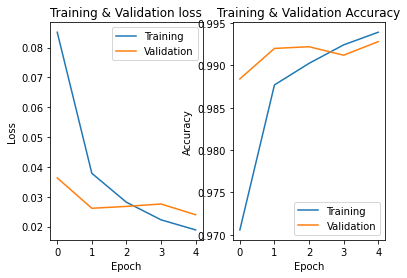

In [23]:
cnn = models.Sequential()
cnn.add(layers.Conv2D(64,(3,3), strides=1, dilation_rate=1, activation = 'relu', input_shape = (28,28,1)))
cnn.add(LayerNormalization(axis=1 , center=True , scale=True))
cnn.add(layers.MaxPooling2D((2,2)))
cnn.add(layers.Conv2D(64,(3,3), strides=1, dilation_rate=1, activation = 'relu'))
cnn.add(LayerNormalization(axis=1 , center=True , scale=True))
cnn.add(layers.Dropout(0.5))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(64,activation='relu',kernel_initializer='he_normal'))
cnn.add(layers.Dense(32,activation='relu',kernel_initializer='he_normal'))
cnn.add(layers.Dense(16,activation='relu',kernel_initializer='he_normal'))
cnn.add(layers.Dense(2,activation='sigmoid'))
cnn.summary()

cnn.compile(optimizer=best_opt, loss='binary_crossentropy', metrics=['accuracy'])
train_results = cnn.fit(train_images, train_labels_oddeven, epochs=5
                  , batch_size=64, validation_data=(val_images,val_labels_oddeven))
print('\nTest:')
test_loss, test_accuracy = cnn.evaluate(test_images, test_labels_oddeven)
GetLossAccuracyPlot()

####Changing the epochs

In [24]:
# epoch ==> 10, 15
epoch = [10, 15]
for i in range(0,len(epoch)):
  print("epoch = ", epoch[i])
  CNN(optimizer_value = best_opt, weight_initializer = 'he_normal', epoch_value = epoch[i])


epoch =  10
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 11, 11, 64)        36928     
_________________________________________________________________
dropout_23 (Dropout)         (None, 11, 11, 64)        0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 7744)              0         
_________________________________________________________________
dense_90 (Dense)             (None, 64)                495680    
_________________________________________________________________
dense_91 (Dense)             (None, 32)  

#Inference

In [40]:
#uncomment the next line to upload if needed
uploaded = files.upload()


Saving 0.jpg to 0.jpg


In [41]:
#list of hand written digit images
imgs = []
imgs.append(cv2.imread("0.jpg"))
imgs.append(cv2.imread("1.jpg"))
imgs.append(cv2.imread("2.jpg"))
imgs.append(cv2.imread("3.jpg"))
imgs.append(cv2.imread("4.jpg"))
imgs.append(cv2.imread("5.jpg"))
imgs.append(cv2.imread("6.jpg"))
imgs.append(cv2.imread("7.jpg"))
imgs.append(cv2.imread("8.jpg"))
imgs.append(cv2.imread("9.jpg"))


In [42]:
#function for image processing
def GetProcessedImg(img):
  #resize and grayscale
  processed_img = cv2.cvtColor(cv2.resize(img,(int(28),int(28))),cv2.COLOR_BGR2GRAY).astype('float32') / 255
  #get binary image
  (threshold,binary_img) = cv2.threshold(processed_img, 0.5, 1, cv2.THRESH_BINARY)
  #return final img
  return np.where(binary_img==0, 1, 0)

#function for predicting labels using last model
def GetOddEvenProdiction(img):
  binary_img = GetProcessedImg(img)
  label = (cnn.predict(binary_img.reshape((1,28, 28, 1)))).argmax(axis=-1)

  f, img_array = plt.subplots(1,2)
  b,g,r = cv2.split(img)
  img = cv2.merge([r,g,b])
  img_array[0].imshow(img)
  img_array[1].imshow(binary_img, cmap=cm.gray)
  plt.show()

  if label == 0:
    print("Digit is EVEN")
  else:
    print("Digit is ODD")
  print('\n\n\n')


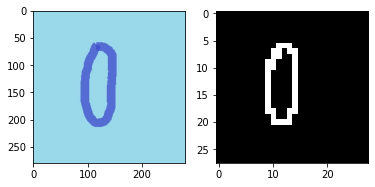

Digit is ODD






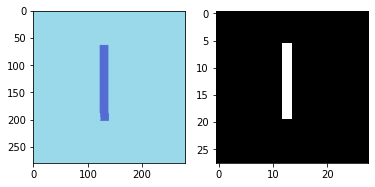

Digit is ODD






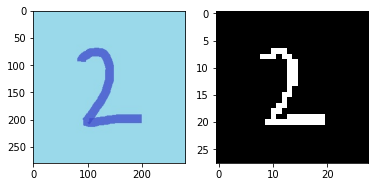

Digit is EVEN






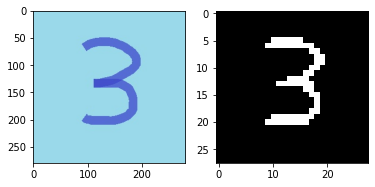

Digit is ODD






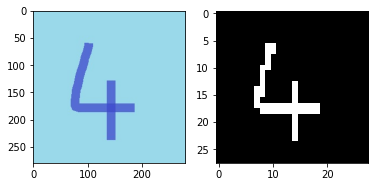

Digit is EVEN






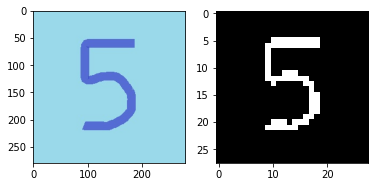

Digit is ODD






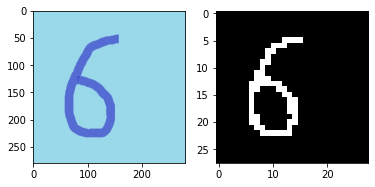

Digit is EVEN






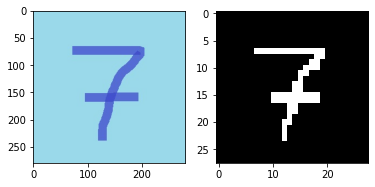

Digit is ODD






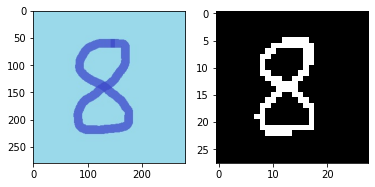

Digit is EVEN






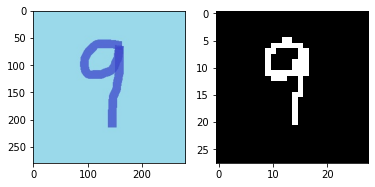

Digit is ODD






In [43]:
#predict odd/even labels
for i in range(0,len(imgs)):
  GetOddEvenProdiction(imgs[i])